# Plotting pseudo-labels (will be removed once function is ready)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from tqdm import tqdm
import laspy

In [4]:
# loading and processing data
# data_folder = r"D:\PDM_repo\Github\PDM\results\trainings\20250507_084214_test"
data_folder = r"D:\PDM_repo\Github\PDM\results\trainings_saved\20250517_145404_first_long_run"
data_folder = r"D:\PDM_repo\Github\PDM\results\trainings_saved\20250523_211714_first_long_run"
data_folder = r"D:\PDM_repo\Github\PDM\results\trainings_saved\20250525_223923_first_long_run"
data_folder = r"D:\PDM_repo\Github\PDM\results\trainings_saved\20250527_095351_first_long_run_modified"

In [5]:
# load and generate data to show
num_loop = 0
count_sem = {}
count_inf = {}
change_from_previous = {}
total_not_change = {}
not_change_in_tile = {}
previous_tiles = {}

# finding the number of loops
lst_loops = []
while True:
    if not str(num_loop) in os.listdir(data_folder):
        break
    lst_loops.append(num_loop)
    num_loop += 1
if num_loop == 0:
    print("No loop folder from which to extract the pseudo-labels")
    quit()   

# processing each loop
for _, num_loop in tqdm(enumerate(lst_loops), total=len(lst_loops), desc="Processing pseudo-labels for visualization"):
    count_sem[num_loop] = {}
    change_from_previous[num_loop] = {}
    total_not_change[num_loop] = {}
    not_change_in_tile[num_loop] = {}
    
    count_inf[num_loop] = []
    for tile_src in os.listdir(os.path.join(data_folder, str(num_loop), "pseudo_labels")):
        tile = laspy.read(os.path.join(data_folder, str(num_loop), "pseudo_labels", tile_src))
        count_sem[num_loop][tile_src] = [ np.sum(tile.classification == x) for x in [0, 1, 4]]
        count_inf[num_loop].append(len(set(tile.treeID)))
        if tile == "color_grp_full_tile_270.laz":
            print(len(set(tile.treeID)), ' - ', set(tile.treeID))
        if num_loop == 0:
            previous_tiles[tile_src] = tile.classification
            change_from_previous[num_loop][tile_src] = [0, 0, 0]
            total_not_change[num_loop][tile_src] = count_sem[num_loop][tile_src]
            not_change_in_tile[num_loop][tile_src] = [True] * len(tile)
        else:
            total_not_change[num_loop][tile_src] = []
            change_from_previous[num_loop][tile_src] = []

            changes = tile.classification != previous_tiles[tile_src]
            not_change_in_tile[num_loop][tile_src] = list(~np.array(changes) & np.array(not_change_in_tile[num_loop - 1][tile_src]))

            # loop on categories
            for cat in [0, 1, 4]:
                mask = tile.classification == cat

                # change from previous
                change_from_previous[num_loop][tile_src].append(np.sum(changes[mask]))

                # total no-change
                total_not_change[num_loop][tile_src].append(np.sum(np.array(not_change_in_tile[num_loop][tile_src]) & np.array(mask)))

            previous_tiles[tile_src] = tile.classification 
    

Processing pseudo-labels for visualization: 100%|██████████| 8/8 [00:27<00:00,  3.46s/it]


In [10]:
# aggregation
categories = ['grey', 'ground', 'tree']
count_sem_agg = {x: [] for x in categories}
count_inf_agg = []
change_from_previous_agg = {x: [] for x in categories}
total_not_change_agg = {x: [] for x in categories}

for num_loop in count_sem.keys():
    count_inf_agg.append(np.mean(list(count_inf[num_loop])))
    for id_cat, cat in enumerate(categories):
        count_sem_agg[cat].append(np.mean([tile_val for tile_val in count_sem[num_loop].values()], axis=0)[id_cat])
        if num_loop > 0:
            change_from_previous_agg[cat].append(np.mean([tile_val for tile_val in change_from_previous[num_loop].values()], axis=0)[id_cat])
        total_not_change_agg[cat].append(np.mean([tile_val for tile_val in total_not_change[num_loop].values()], axis=0)[id_cat])

In [11]:
# total points
total_points = 0
list_tiles = [x for x in os.listdir(os.path.join(data_folder, "pseudo_labels")) if x.endswith('.laz')]
for tile_src in list_tiles:
        tile = laspy.read(os.path.join(data_folder, "pseudo_labels", tile_src))
        total_points += len(tile.points)
print("Total points: ", total_points)
count_sem_prop = {x:[] for x in count_sem_agg.keys()}
count_sem_prop_inv = {x:[] for x in count_sem_agg.keys()}

for key in count_sem_prop.keys():
        # count_sem_prop[key] = [x / total_points * 100 for x in count_sem_agg[key]]
        # count_sem_prop_inv[key] = [100 - x / total_points * 100 for x in count_sem_agg[key]]
        count_sem_prop[key] = [x for x in count_sem_agg[key]]
        count_sem_prop_inv[key] = [total_points - x for x in count_sem_agg[key]]

Total points:  12847453


[119779.15, 115458.2, 113049.7, 111973.8, 111332.9, 111219.7, 111081.8, 111069.85]
[12727673.85, 12731994.8, 12734403.3, 12735479.2, 12736120.1, 12736233.3, 12736371.2, 12736383.15]
[5.07838123 5.06242478 5.05326941 5.04911642 5.04662352 5.04618172
 5.04564291 5.04559619]
[-7.104749037870446, -7.104896452574494, -7.104978599901233, -7.105015290877986, -7.10503714575488, -7.105041005793612, -7.105045708038257, -7.105046115518264]
[-8. -6. -4. -2.  0.  2.  4.  6.]


C:\Users\swann\AppData\Local\Temp\ipykernel_18292\2192093368.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels([f"$10^{int(np.abs(x))}$" for x in ax[0].get_yticks()])


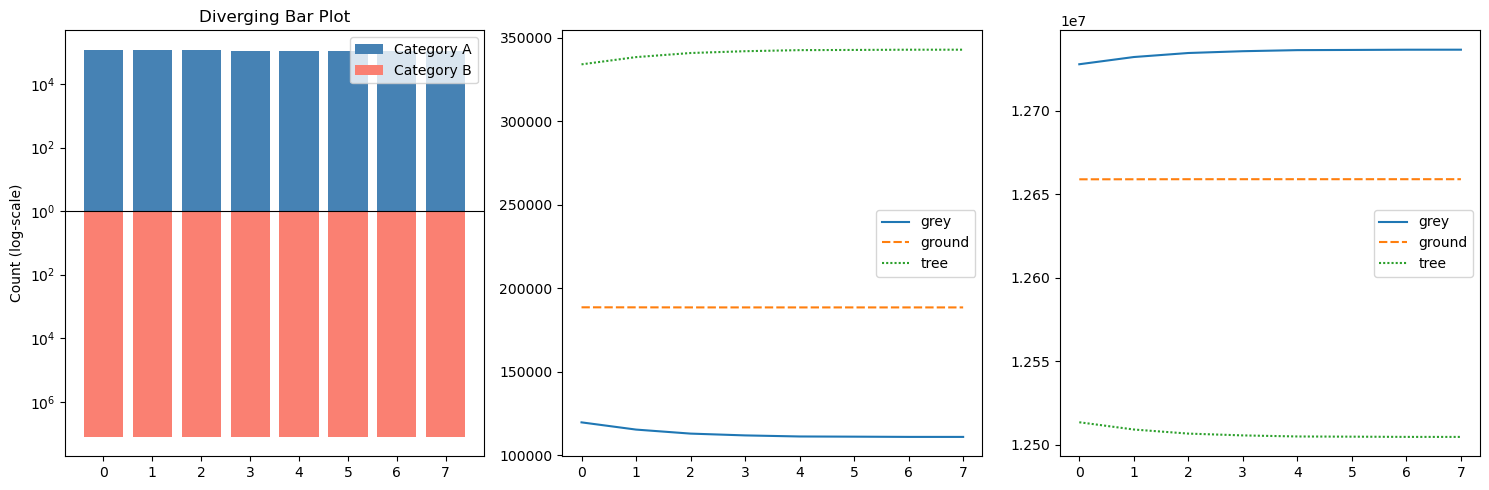

In [12]:
# Example data
labels = ['Item 1', 'Item 2', 'Item 3']
# above = [0.7, 0.4, 0.6]   # e.g., % of category A
# below = [0.3, 0.6, 0.4]   # e.g., % of category B
above = count_sem_prop['grey']
below = count_sem_prop_inv['grey']

# x = np.arange(len(labels))
x = np.arange(len(count_sem_prop['grey']))

# above = [2, 0.5, 3]
# below = [100 - x for x in above]
# x = np.arange(len(above))
fig, ax = plt.subplots(1,3, figsize=(15, 5))
print(above)
print(below)
print(np.log10(above))
print([-np.log10(b) for b in below])
# Plot the bars
ax[0].bar(x, np.log10(above), label='Category A', color='steelblue')
ax[0].bar(x, [-np.log10(b) for b in below], label='Category B',  color='salmon')

# Customizing the plot
ax[0].set_xticks(x)
print(ax[0].get_yticks())
# ax[0].set_ytickslables()
ax[0].set_yticklabels([f"$10^{int(np.abs(x))}$" for x in ax[0].get_yticks()])
ax[0].axhline(0, color='black', linewidth=0.8)
ax[0].set_ylabel('Count (log-scale)')
ax[0].set_title('Diverging Bar Plot')
ax[0].legend()

sns.lineplot(pd.DataFrame(count_sem_prop), ax=ax[1])
sns.lineplot(pd.DataFrame(count_sem_prop_inv), ax=ax[2])

plt.tight_layout()
plt.show()

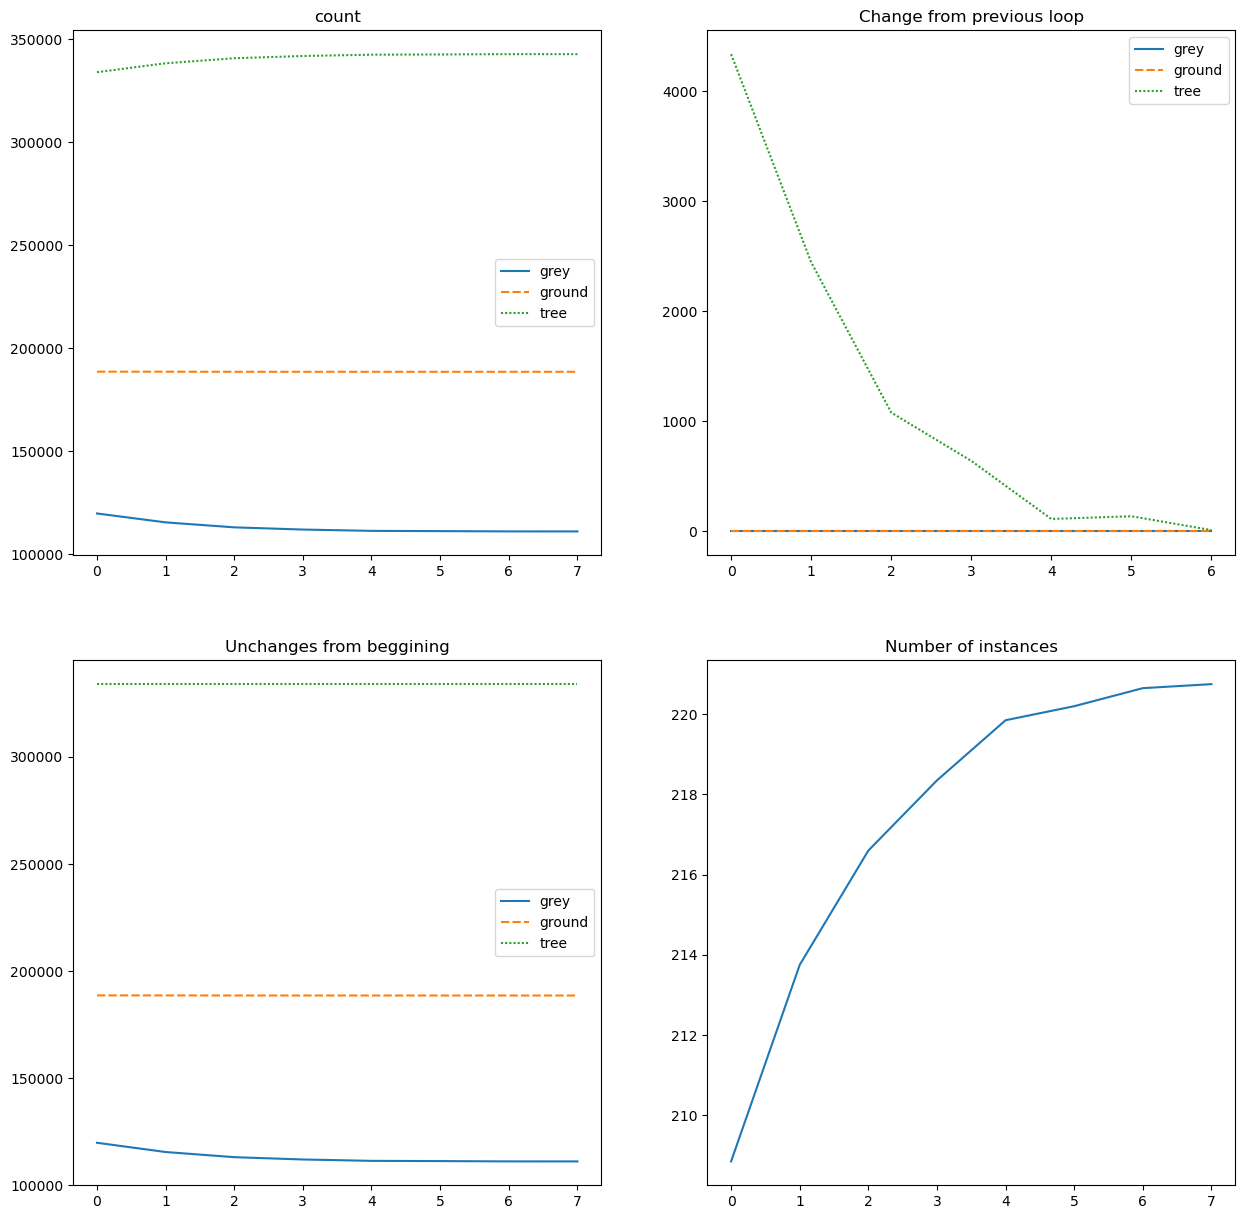

In [ ]:
# visualizing
fig, axs = plt.subplots(2,2, figsize=(15,15))
axs = axs.flatten()
sns.lineplot(pd.DataFrame(count_sem_agg), ax=axs[0])
sns.lineplot(pd.DataFrame(change_from_previous_agg), ax=axs[1])
sns.lineplot(pd.DataFrame(total_not_change_agg), ax=axs[2])
sns.lineplot(count_inf_agg, ax=axs[3])
# fig.delaxes(axs[3])

#   _titles and labels
axs[0].set_title('count')
axs[1].set_title('Change from previous loop')
axs[2].set_title('Unchanges from beggining')
axs[3].set_title('Number of instances')

plt.show()

### Visualizing instances

In [36]:
# loading and processing data
data_folder = r"D:\PDM_repo\Github\PDM\results\trainings\20250507_084214_test"
# data_folder = r"D:\PDM_repo\Github\PDM\results\trainings_saved\20250517_145404_first_long_run"

# load and generate data to show
num_loop = 0
count_inf= {}
change_from_previous = {}
total_not_change = {}
not_change_in_tile = {}
previous_tiles = {}

# finding the number of loops
lst_loops = []
while True:
    if not str(num_loop) in os.listdir(data_folder):
        break
    lst_loops.append(num_loop)
    num_loop += 1
if num_loop == 0:
    print("No loop folder from which to extract the pseudo-labels")
    quit()   

# processing each loop
for _, num_loop in tqdm(enumerate(lst_loops), total=len(lst_loops), desc="Processing pseudo-labels for visualization"):
    count_inf[num_loop] = {}
    change_from_previous[num_loop] = {}
    total_not_change[num_loop] = {}
    not_change_in_tile[num_loop] = {}
    for tile_src in os.listdir(os.path.join(data_folder, str(num_loop), "pseudo_labels")):
        tile = laspy.read(os.path.join(data_folder, str(num_loop), "pseudo_labels", tile_src))
        # print(list(tile.point_format.dimension_names))
        # break
        # count[num_loop][tile_src] = [ np.sum(tile.classification == x) for x in [0, 1, 4]]
        count_inf[num_loop][tile_src] = len(set(tile.treeID))
        points_per_cluster = count_sem[num_loop][tile_src][2] / count_inf[num_loop][tile_src]
        print(count_inf[num_loop][tile_src], ' - ', points_per_cluster)

        continue

        if num_loop == 0:
            previous_tiles[tile_src] = tile.classification
            change_from_previous[num_loop][tile_src] = [0, 0, 0]
            total_not_change[num_loop][tile_src] = count[num_loop][tile_src]
            not_change_in_tile[num_loop][tile_src] = [True] * len(tile)
        else:
            total_not_change[num_loop][tile_src] = []
            change_from_previous[num_loop][tile_src] = []

            changes = tile.classification != previous_tiles[tile_src]
            not_change_in_tile[num_loop][tile_src] = list(~np.array(changes) & np.array(not_change_in_tile[num_loop - 1][tile_src]))

            # loop on categories
            for cat in [0, 1, 4]:
                mask = tile.classification == cat

                # change from previous
                change_from_previous[num_loop][tile_src].append(np.sum(changes[mask]))

                # total no-change
                total_not_change[num_loop][tile_src].append(np.sum(np.array(not_change_in_tile[num_loop][tile_src]) & np.array(mask)))

            previous_tiles[tile_src] = tile.classification 

Processing pseudo-labels for visualization:   0%|          | 0/3 [00:00<?, ?it/s]

104  -  1188.3173076923076
30  -  1525.9
156  -  1812.371794871795
163  -  2246.6134969325153
181  -  2192.4364640883978
151  -  1930.7880794701987
193  -  2253.6321243523316
165  -  2132.5939393939393
187  -  1720.6363636363637


Processing pseudo-labels for visualization:  33%|███▎      | 1/3 [00:00<00:01,  1.06it/s]

20  -  1055.85
14  -  668.6428571428571
54  -  921.8888888888889
132  -  1468.719696969697
28  -  1632.25
152  -  1597.5526315789473
163  -  2172.8282208588957
178  -  2085.3651685393256
147  -  1696.1700680272108
193  -  1863.3834196891191
159  -  1893.811320754717
184  -  1405.016304347826
21  -  1366.8095238095239
14  -  926.2142857142857


Processing pseudo-labels for visualization:  67%|██████▋   | 2/3 [00:01<00:00,  1.05it/s]

53  -  1058.2830188679245
139  -  1691.3597122302158
25  -  1706.12
152  -  1839.828947368421
162  -  2269.3456790123455
172  -  2303.3546511627906
143  -  1955.4545454545455
189  -  1921.1904761904761
151  -  2214.9602649006624


Processing pseudo-labels for visualization: 100%|██████████| 3/3 [00:02<00:00,  1.05it/s]

175  -  1622.1771428571428
23  -  1600.4782608695652
13  -  1555.7692307692307
51  -  1400.7843137254902


In [8]:
import os
from os.path import dirname
src = r"D:\PDM_repo\Github\PDM\results\trainings\20250523_154913_first_long_run"
print((os.path.basename(src)))

20250523_154913_first_long_run


[[0.86864282 0.84043779 0.35282786 0.6577453  0.9717514  0.62591276
  0.88245889 0.49372439 0.12690322 0.11829853]
 [1.20540156 1.71019122 2.52221218 1.41532148 1.30050923 1.17141195
  1.83543559 1.4904443  2.49199549 2.2685636 ]
 [4.1881655  2.63224943 3.08349445 3.74232268 3.91540892 2.19733433
  2.69608374 3.47419397 4.19586223 3.89253356]
 [6.81165847 3.82910993 4.88698173 3.16274468 3.38738153 6.24590777
  4.50520587 6.84210991 3.51296831 4.97857086]]


Text(0, 0.5, 'Perf [-]')

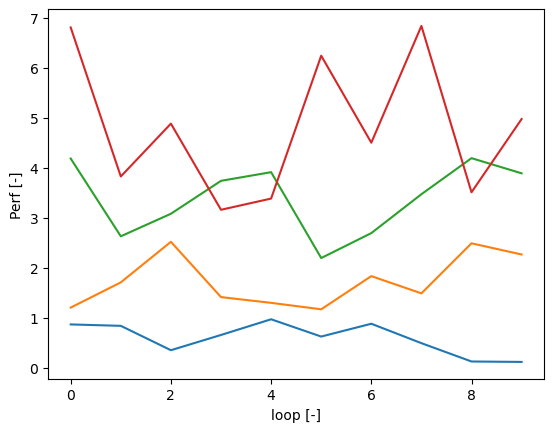

In [25]:
arr = np.random.rand(4,10).T * np.arange(1,5) + np.arange(4)
print(arr.T )
fig = plt.figure()
plt.plot(arr)
plt.xlabel('loop [-]')
plt.ylabel('Perf [-]')